In [1]:
# For wider display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#### Block 1 #### Please refer to this number in your questions
import subprocess
from multiprocessing import Pool, cpu_count
import os, pickle, math

import numpy as np
from numpy.linalg import inv

import matplotlib.pyplot as plt
import seaborn as sns
sns.set("notebook")
sns.color_palette('bright')
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl

import scipy.stats as st
from scipy import optimize
from scipy.linalg import lapack

from pyDOE import lhs
import emcee
import h5py

np.random.seed(1)

# You can find the results, plots and saved d
project = "SimpleBulk"
FIGURE_ID = project + '/plots' # save all figures
DATA_ID = project + "/Data" # save design points (model calculations + design parameter)
for it in [project, FIGURE_ID, DATA_ID]:
    os.makedirs(it, exist_ok=True)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(os.path.join(FIGURE_ID, fig_id) + ".png", format='png', dpi=300)
    
def hist_1d_2d(X, Y, nameX, nameY):
    left, width = 0.1, 0.75
    bottom, height = 0.1, 0.75
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.15]
    rect_histy = [left + width + spacing, bottom, 0.15, height]

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes(rect_scatter)
    ax1 = fig.add_axes(rect_histx, sharex=ax)
    ax2 = fig.add_axes(rect_histy, sharey=ax)
    ax1.tick_params(axis="x", labelbottom=False)
    ax2.tick_params(axis="y", labelleft=False)

    ax.scatter(X, Y)
    ax1.hist(X, density=True)
    ax2.hist(Y, orientation='horizontal', density=True)
    ax.set_xlabel(nameX)
    ax.set_ylabel(nameY)


# Bayesian Parameter Inference: a *simple* model for bulk physics.

### Bulk models:
1. Initial condition: initial condition energy density, geometry, $e(x_\perp)$
2. Dynamical models (JETSCAPE):
   * Preequilbirum evolution
   * Hydrodynamic evolution (take $\eta/s(T), \zeta/s(T)$ as input)
   * Particlziation + hadronic scatterings / decays
3. Bulk observables: dynamical evolution translates initial condition into final-state observables such as
   * particle multiplicity
   * anisotropy flows and correlations
   * ...

### Target quantity $\eta/s(T)$: 
We want extract the temperature-dependent shear viscosity. It is parameterized as (same functional form as in recent JETSCAPE paper https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.126.242301 )
$$\frac{\eta}{s}(T) = a + 
\begin{cases} 
b (T - d), & T>d\\
c (d - T), & T<d\\
\end{cases}
$$

### A simple dynamic model used in this notebook:
We consider hydrodynamic-like response to the centrality averaged initial condition quantities: unnormalized multiplicity $\sim d\tilde{E}_T/d\eta_s$ ($\tilde{E}_T$ for short), unnormalized avaraged initial temperature $\langle \tilde{T}_0 \rangle$, and initial geoemtric eccentricity $\epsilon_2$. We assume they are mapped to the final-state charged particle multiplictiy and elliptic flow via an "evolution history averaged" viscosity (https://arxiv.org/abs/1912.06287) $$(\eta/s)_{\rm eff} = \frac{\int_{T_1}^{T_0} T^{p} \left(\eta/s\right)_T dT }{\int_{T_1}^{T_0} T^{p} dT } $$ ($p$ controls the sensitvitiy to high-$T$ values of $\eta/s$, let's take $p=-1$ for now)
and 
$$
N_{\rm ch} = {\rm Norm} \cdot \tilde{E}_T  \left[1 + (\eta/s)_{\rm eff}\right], \quad \quad v_2 = \epsilon_2 \cdot \exp\left[-50\frac{(\eta/s)_{\rm eff}}{N_{\rm ch}^{1/3}}\right]
$$
Parameters: $\{{\rm Norm}, a, b, c, d\}$.



In [3]:
Tpower = -1
Tmin = 0.13

/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


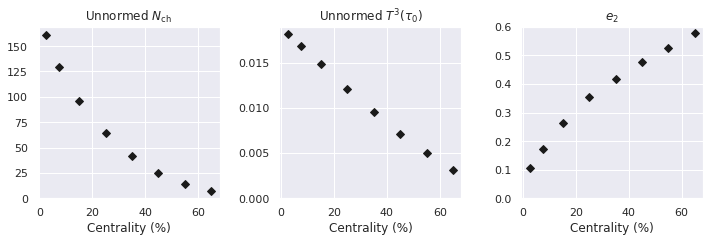

In [5]:
#### Block 2 #### Please refer to this number in your questions
cen, _, _, ET, ed, e2 = np.loadtxt(DATA_ID+"/Geometry_info.dat").T
fig, axes = plt.subplots(1,3, figsize=(10,3.5), sharex=True)
titles = [r"Unnormed $N_{\rm ch}$", r"Unnormed $T^3(\tau_0)$", r"$e_2$"]
for ax,y,name in zip(axes, [ET, ed, e2], titles):
    ax.plot(cen, y, 'kD')
    ax.set_title(name)
    ax.set_xlabel("Centrality (%)")
    ax.set_ylim(ymin=0)
plt.tight_layout(True)
save_fig("Initial_condition")

In [6]:
#### Block 3 #### Please refer to this number in your questions
# Toy model of a hydro-like repsonse to eccentricity
from scipy.integrate import quad
def etas(T, params):
    etasA, etasB, etasC, etasD = params
    res = etasA + etasB*(T-etasD)*(T>etasD) + etasC*(etasD-T)*(T<etasD)
    if not hasattr(T, "__len__"):
        return np.max([res, 0.])
    else:
        res[res<0.] = 0.
        return res

def etas_eff(Tmax, params):
    N = quad(lambda T: T**Tpower * etas(T, params), Tmin, Tmax)[0]
    D = quad(lambda T: T**Tpower, Tmin, Tmax)[0]
    return N/D

def ToyModel(params):
    norm = params[0]
    Tmax_array = (norm*ed)**(1./3.)
    etas_avg = np.array([etas_eff(Tmax, params[1:]) for Tmax in Tmax_array])
    mult = norm * ET * (1. + etas_avg)
    v2 = e2 * np.exp(- 50 * etas_avg / (mult)**.3333 ) 
    return mult, v2

## Step 1: Make Design

We will sample 200 design points in the 5-dimensional parameter space (50/Dimension). Set the `read_design_from_file` to decide whether read exisiting design points.

In [15]:
#### Block 4 #### Please refer to this number in your questions
ParameterLabels = ['$N$', '$\eta/s(A)$', '$\eta/s(B)$', '$\eta/s(C)$', '$\eta/s(D)$']
Xdim = len(ParameterLabels) # dimension of the parameter space
Ndesign = 200
read_design_from_file = False
if read_design_from_file:
    design_df = pd.read_csv(data_path('design'))
    design = design_df.values
    ranges_df = pd.read_csv(data_path('designRange'))
    ranges = ranges_df.values
    print(f'Load design from file. Design shape is {design.shape}')
else:
    # range of the design, save to file
    ranges = np.array([
        [6,15],[.02, 0.2],[-1,4],[0,10],[0.1, 0.4]
    ])
    ranges_df = pd.DataFrame(ranges, columns=['min','max'], index=ParameterLabels)
    ranges_df.to_csv(data_path('designRange'), index=False)
    # First make a Latin-Hypercube design within the Xdim unit cube [0,1]^Xdim
    np.random.seed(1)
    unit = lhs(ranges.shape[0], samples=Ndesign, criterion='maximin')
    # Then, rescale the design tot he desired range
    design = ranges[:,0] + unit*(ranges[:,1]-ranges[:,0])
    # Save to file
    design_df = pd.DataFrame(design, columns=ParameterLabels)
    design_df.to_csv(data_path('design'), index=False)

In [16]:
#### Block 5 #### Please refer to this number in your questions
# Define the min and max boundary of the design
design_max = ranges[:,1]
design_min = ranges[:,0]
# The range of the design is an important reference length scale when we train the emulator 
design_ptp = design_max - design_min
ranges_df.head() 

,min,max
$N$,6.00,15.0
$\eta/s(A)$,0.02,0.2
$\eta/s(B)$,-1.00,4.0
$\eta/s(C)$,0.00,10.0
$\eta/s(D)$,0.10,0.4


In [17]:
#### Block 6 #### Please refer to this number in your questions
design_df.head() 

,$N$,$\eta/s(A)$,$\eta/s(B)$,$\eta/s(C)$,$\eta/s(D)$
0,9.360650,0.062268,-0.649710,9.899649,0.246318
1,11.944346,0.072678,3.128238,6.480579,0.313781
2,6.924985,0.074209,2.940444,1.534215,0.153772
3,9.522609,0.150871,-0.053252,1.692241,0.237194
4,9.919938,0.049491,3.893685,6.096537,0.162002


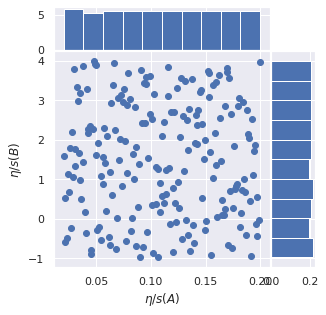

In [18]:
#### Block 7 #### Please refer to this number in your questions
i,j = 1,2
hist_1d_2d(design[:,i], design[:,j], ParameterLabels[i], ParameterLabels[j])
save_fig("Check_design")

## Step 2: compute model at each design point

This simple model only take seconds to finish. However, this is usually the most time-consuming part of the analysis for realistic bulk model. 

In [19]:
#### Block 8 #### Please refer to this number in your questions
#Simulation outputs at the design points
simulation = np.array([np.concatenate(ToyModel(param)) for param in design])
Ydim = simulation.shape[1]

## Step 3: Build Emulators for the model

### 3.1: dimensional reduction
We will use a technique called "Principal component analysis" (PCA) to find the few most dominate features in the training data. As a result, insteading of using 10 values of $dN_{\rm ch}/d\eta$ and $v_2$ to represent the model at a parameter point, we can use a few ($n\ll 10$) coefficients of the features of represent the model, i.e., bears the name "dimensional reduction".

Here, we will not go into the full details of PCA. But a requirement for PCA to be efficiently applied, the data better follows a multi-variate normal distributions when you randomly sample the parameter point. Otherwise, one need to think of good ways to transform the data before apply the PCA. This will get clear in the following exercise.

1. Make a scatter plot where  $X=dN_{\rm ch}/d\eta[0-5\%]$ and $Y=v_2[0-5\%]$ from all the deisgn points. Does the joint distribution looks like a 2D-normal distribution to you?

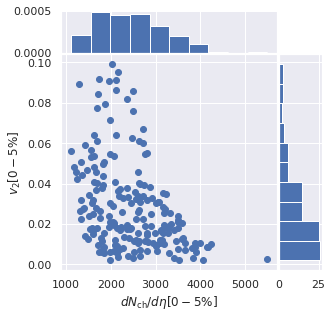

In [20]:
#### Block 9 #### Please refer to this number in your questions
Nc = len(cen)
X = simulation[:,0]
Y = simulation[:, Nc]
hist_1d_2d(X, Y, r"$dN_{\rm ch}/d\eta[0-5\%]$", r"$v_2[0-5\%]$")
save_fig("Check_design_obs")

2. The above data clearly does not resembles a 2D normal distribution. But often a simple transformation works. Now, plot $\sqrt{dN_{\rm ch}/d\eta[0-5\%]}$ v.s. $\sqrt{v_2[0-5\%]}$ and check the distribution

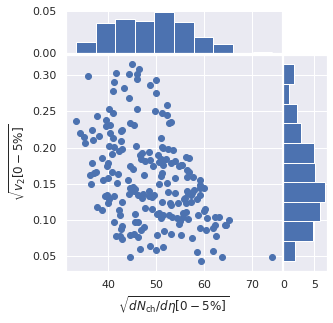

In [21]:
#### Block 10 #### Please refer to this number in your questions
hist_1d_2d(np.sqrt(X), np.sqrt(Y), r"$\sqrt{dN_{\rm ch}/d\eta[0-5\%]}$", r"$\sqrt{v_2[0-5\%]}$")
save_fig("Check_design_tranformed_obs")

It is not perfect, but now the distribution looks more like a normal distribution, which is importance for high-performance PCA. Note that the transofrmation stress out the dense region in the previous plot and reduce the degree of non-linear correlation. From now on, we will build emulators that learns how to map novel sets of parameters to $Y_{\rm model} = \left\{ \sqrt{dN_{\rm ch}/d\eta}, \sqrt{v_2} \right\}$

In [22]:
#### Block 10 #### Please refer to this number in your questions
use_NL = True
Y_model = np.sqrt(simulation) if use_NL else simulation

3. Standardlized the distribuiton $\tilde{Y} = (Y-\bar{Y})/\sigma_Y$ for each observable. This way the PCA algorith does not need to handle extremely large/small numbers or biased distributions that does not centered around zero. This so-called ``StandardScaler'' class in sklearn takes care this transfomation and its inverse transformation.

In [23]:
#### Block 11 #### Please refer to this number in your questions
#Scaling the data to be zero mean and unit variance for each feature
SS  =  StandardScaler(copy=True)

4. Apply the principal component analysis as implemented by sklearn, and we will only keep the first $N_{\rm pc}$ features (principal components) of the data

In [25]:
#### Block 12 #### Please refer to this number in your questions
Npc = 3
pca = PCA(copy=True, whiten=True, svd_solver='full')
# Keep only the first `npc` principal components
pc_tf_data = pca.fit_transform(SS.fit_transform(Y_model)) [:,:Npc]

# The transformation matrix from PC to Physical space
inverse_tf_matrix = pca.components_ * np.sqrt(pca.explained_variance_[:, np.newaxis]) * SS.scale_ 
inverse_tf_matrix = inverse_tf_matrix[:Npc,:]

5. How do we know 3 features are enought. We can take a look at the ``importance'' of (data variance contained in) each principal components / features. You will find that the first 3 feaures already explain more than 99% of the total data variance.

/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  


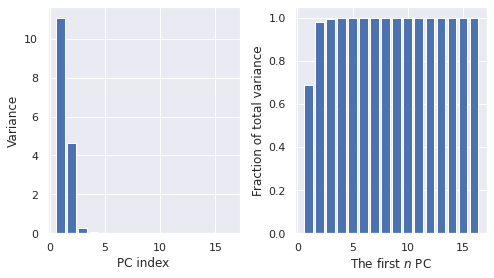

In [26]:
#### Block 13 #### Please refer to this number in your questions
# print the explained raito of variance
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,4))
#importance = pca_analysis.explained_variance_
importance = pca.explained_variance_
cumulateive_importance = np.cumsum(importance)/np.sum(importance)
idx = np.arange(1,1+len(importance))
ax1.bar(idx,importance)
ax1.set_xlabel("PC index")
ax1.set_ylabel("Variance")
ax2.bar(idx,cumulateive_importance)
ax2.set_xlabel(r"The first $n$ PC")
ax2.set_ylabel("Fraction of total variance")
plt.tight_layout(True)
save_fig("PC_importance")

### 3.2 Training Gaussian process emulators

In [27]:
#### Block 14 #### Please refer to this number in your questions
import time
overide = True
EMU = "emulators.dat"
if (os.path.exists(data_path(EMU))) and (overide==False):
    print('Saved emulators exists and overide is prohibited')
    with open(data_path(EMU),"rb") as f:
        Emulators=pickle.load(f)
else:
    Emulators=[]
    for i in range(0,Npc):
        start_time = time.time()
        kernel=1*krnl.RBF(length_scale=design_ptp,
                          length_scale_bounds=np.outer(design_ptp, (1e-2, 1e2)))\
               + krnl.WhiteKernel(noise_level=.1, 
                                  noise_level_bounds=(1e-2, 1e2))
        print("-----------------")
        print("Training PC #",i+1)
        GPR=gpr(kernel=kernel,n_restarts_optimizer=5)
        GPR.fit(design, pc_tf_data[:,i].reshape(-1,1))
        print('GPR score: {:1.3f}'.format(GPR.score(design,pc_tf_data[:,i])) )
        #print(f'GPR log_marginal likelihood {GPR.log_marginal_likelihood()} \n')
        print("time: {:1.3f} seconds".format(time.time() - start_time))
        Emulators.append(GPR)

if (overide==True) or not (os.path.exists(data_path(EMU))):
    with open(data_path(EMU), "wb") as f:
        pickle.dump(Emulators,f)
        

-----------------
Training PC # 1
GPR score: 0.998
time: 0.571 seconds
-----------------
Training PC # 2
GPR score: 0.998
time: 0.750 seconds
-----------------
Training PC # 3
GPR score: 0.997
time: 1.177 seconds


In [28]:
#### Block 15 #### Please refer to this number in your questions

# This function takes model parmaeters, 
# 1. gets GP emulator prediction on principal components
# 2. inverse transform of  PCA+standard scaler
# 3. inverse transform the sqrt(*) non-linear transformation that we add by hand
def predict_observables(model_parameters, diag_std=False):
    """Predicts the observables for any model parameter value using the trained emulators.
    
    Parameters
    ----------
    Theta_input : Model parameter values.
    Return
    ------
    Mean value and full error covaraiance matrix of the prediction is returened. """
    
    mean=[]
    variance=[]
    theta=np.array(model_parameters).flatten()
    
    if len(theta)!=Xdim:
        raise TypeError('The input model_parameters array does not have the right dimensions')
    else: 
        theta=np.array(theta).reshape(1,Xdim)
        for i in range(Npc):
            mn,std=Emulators[i].predict(theta, return_std=True)
            mean.append(mn)
            variance.append(std**2)
    mean=np.array(mean).reshape(1,-1)
    inverse_transformed_mean = mean@inverse_tf_matrix + np.array(SS.mean_).reshape(1,-1)
    if use_NL:
        inverse_transformed_mean = inverse_transformed_mean**2
    
    variance_matrix = np.diag(np.array(variance).flatten())
    inverse_transformed_variance = np.einsum('ik,kl,lj-> ij', inverse_tf_matrix.T, variance_matrix, inverse_tf_matrix, 
                                             optimize=False)
    if use_NL:
        inverse_transformed_variance *= np.outer(2.*inverse_transformed_mean[0]**.5, 
                                                 2.*inverse_transformed_mean[0]**.5)
    if diag_std:
        return inverse_transformed_mean[0], np.sqrt(np.diag(inverse_transformed_variance))
    else:
        return inverse_transformed_mean[0], inverse_transformed_variance

### 3.3 Emulator validation

Before applying the above model predictor based on PCA+GP, it is impertaive to validate its performance.
The most straight forward way is to 

1. Sample novel parameters sets other than those used to train GPs. 
2. Compare GP prediction to the physical model calculations at these novel parameter points

/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


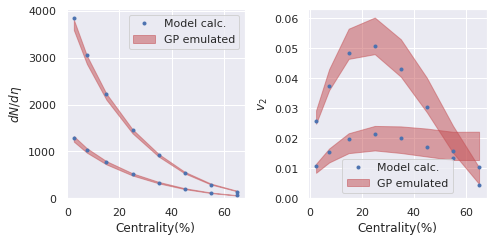

In [29]:
#### Block 16 #### Please refer to this number in your questions
# randomly sample another 2 parametr points from the parameter space
np.random.seed(8)
X_validation = design_min + np.random.rand(2, Xdim)*design_ptp

# Next, get the emulator prediction and uncertainty
A = np.array([predict_observables(it, diag_std=True) for it in X_validation])
Y_predicted = A[:,0,:]
Y_std = A[:,1,:]

# Model calculation at these two points
Y_validation = np.array([np.concatenate(ToyModel(param)) for param in X_validation])

# plot the prediction + uncertainty band with the true model caluclation
fig, axes = plt.subplots(1,2, figsize=(7,3.5), sharex=True)
for i, (mean, std) in enumerate(zip(Y_predicted, Y_std)):
    label = 'GP emulated' if i==0 else''
    axes[0].fill_between(cen,mean[:Nc]-std[:Nc],mean[:Nc]+std[:Nc],color='r',alpha=.5, label=label)
    axes[1].fill_between(cen,mean[Nc:]-std[Nc:],mean[Nc:]+std[Nc:],color='r',alpha=.5, label=label)
for i, ym in enumerate(Y_validation):
    label = 'Model calc.' if i==0 else''
    axes[0].plot(cen, ym[:Nc], 'b.', label=label)
    axes[1].plot(cen, ym[Nc:], 'b.', label=label)

# Add labels
labels = r"$dN/d\eta$", r"$v_2$", r"$", r"$dN/d\eta$: pred-true", r"$v_2$: pred-true"
for ax, label in zip(axes, labels):
    ax.set_xlabel("Centrality(%)")
    ax.set_ylabel(label)
    ax.legend()
    ax.set_ylim(ymin=0)
plt.tight_layout(True)
save_fig("Emulator_validation_1")

We know that emulaotr prediction is not perfect and it estimates its own interpolation uncertainty. How do we know the emulation is consistent with model calcualtion within uncertainty?

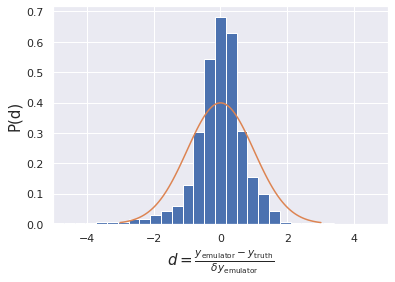

In [30]:
#### Block 17 #### Please refer to this number in your questions

# Test more extensively! Sample 100 more validation points
X_validation = design_min + np.random.rand(100, Xdim)*design_ptp
Y_validation = np.array([np.concatenate(ToyModel(param)) for param in X_validation])

A = np.array([predict_observables(it, diag_std=True) for it in X_validation])
Y_predicted = A[:,0,:]
Y_std = A[:,1,:]

# This time, we use a self-normalized quantity to check if the uncertainty estimation is
# resaonble: delta = (y_emulated - y_model)/std_emulated
normalized_discrepancy = ((Y_predicted - Y_validation)/Y_std).flatten()
_ = plt.hist(normalized_discrepancy, bins=31, range=[-5,5], density=True)

# It should look like a standard normal distribution
x = np.linspace(-3,3,100)
from scipy.stats import norm
plt.plot(x, norm.pdf(x,0,1))
plt.xlabel(r"$d=\frac{y_{\rm emulator}-y_{\rm truth}}{\delta y_{\rm emulator}}$", fontsize=15)
plt.ylabel(r"P(d)", fontsize=15)
plt.xlim(-5,5)
save_fig("Emulator_validation_self_normed")

## Step 4: Bayesian Inference

### 4.1: Define experimental dataset, uncertainty, and experimental covariance matrix

In this exercises, we use the so-called "Pseudodata". Pseudodata uses the model calulations from a specific set of parameters. This set of parameters is the "true value" that can be compared with the posterior.

/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


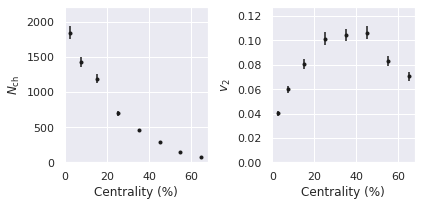

In [31]:
#### Block 18 #### Please refer to this number in your questions
# Pseudo data generated with "true" parameters
true_values = np.array([9.0, 0.1, 1, 4, 0.18])
y_exp = np.concatenate( ToyModel(true_values) )

# Put in statistical flucuation in the Pseudodata
stat_level = 0.05
np.random.seed(5)
y_exp *= (1. + np.random.normal(0,stat_level,len(y_exp)))

# But we know there is a 5% stat uncertainty
y_stat = y_exp * stat_level
# this is used to construct the experimetnal uncertainty.
y_exp_variance = np.diag(y_stat**2)

fig, axes = plt.subplots(1,2, figsize=(6,3), sharex=True)
for ax,y,name in zip(axes, 
                    [y_exp[:Nc], y_exp[Nc:]],
                    [r"$N_{\rm ch}$", r"$v_2$"]):
    ax.errorbar(cen, y, yerr=y*stat_level, fmt='k.')
    ax.set_ylabel(name)
    ax.set_xlabel("Centrality (%)")
    ax.set_ylim(ymin=0, ymax=y.max()*1.2)
plt.tight_layout(True)
save_fig("Pseudodata")

### 4.2: Define prior, likelihood and posterior distribution

In [32]:
#### Block 19 #### Please refer to this number in your questions
def log_prior(model_parameters):
    """Evaluvate the prior at model prameter values. 
    If all parameters are inside bounds function will return 0 otherwise -inf"""
    X = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= design_min)
    upper = np.all(X <= design_max)
    if (lower and upper):
        lp=0
    # lp = np.log(st.beta.pdf(X,5,1,dsgn_min_ut.reshape(1,-1),(dsgn_max_ut-dsgn_min_ut).reshape(1,-1))).sum()
    else:
        lp = -np.inf
    return lp

In [33]:
#### Block 20 #### Please refer to this number in your questions
def mvn_loglike(y, cov):
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
         )

    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        return -.5*np.dot(y, alpha) - np.log(np.abs(L.diagonal())).sum()
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )

In [34]:
#### Block 21 #### Please refer to this number in your questions
# Covariance truncation error from PC is not yet included
def log_posterior(model_parameters):
    mn, var = predict_observables(model_parameters)
    delta_y = mn - y_exp
    delta_y = delta_y.flatten()   
    total_var = var + y_exp_variance
    return log_prior(model_parameters) + mvn_loglike(delta_y,total_var)

### 4.3: Draw random samples according to the posterior distribution using the Markov-chain Monte-Carlo (MCMC) method

In [35]:
## deactivate Burn option

#### Block 22 #### Please refer to this number in your questions
do_mcmc = True
nwalkers = 10*Xdim  # number of MCMC walkers
nburn = 500 # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take
filename = data_path(name+".h5")

if do_mcmc==True:
    #backend = emcee.backends.HDFBackend(filename)
    starting_guesses = design_min + (design_max - design_min) * np.random.rand(nwalkers, Xdim)
    #print(starting_guesses)
    print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, Xdim, log_posterior)
        print('burn in sampling started')    
        pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
        print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nburn))
        print('Burn in completed.')
        print("Now running the samples")
        sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
        print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                        np.mean(sampler.acceptance_fraction), nwalkers*nsteps))
        
        # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, Xdim)
        #samples = backend.get_chain(flat=True, discard=nburn)
        samples = sampler.get_chain(flat=True, discard=nburn)
        samples_df = pd.DataFrame(samples, columns=ParameterLabels)
        samples_df.to_csv(data_path('ChainForSImpleModel'), index=False)
else:
    #df1=h5py.File(filename,mode='r')
    print('Loading chain from disk')
    samples_df=pd.read_csv(data_path('ChainForSImpleModel'))
    samples= samples_df.values
samples_df.head()

MCMC sampling using emcee (affine-invariant ensamble sampler) with 50 walkers


  0%|          | 0/500 [00:00<?, ?it/s]

burn in sampling started


  0%|          | 3/2000 [00:00<01:16, 25.94it/s]

Mean acceptance fraction: 0.369 (in total 25000 steps)
Burn in completed.
Now running the samples


100%|██████████| 2000/2000 [00:56<00:00, 35.27it/s]


Mean acceptance fraction: 0.333 (in total 100000 steps)


,$N$,$\eta/s(A)$,$\eta/s(B)$,$\eta/s(C)$,$\eta/s(D)$
0,9.347619,0.054080,1.644434,1.958803,0.250681
1,9.982645,0.144405,0.973180,0.559159,0.229615
2,9.297396,0.089428,1.534148,2.335612,0.230885
3,8.767309,0.136926,2.382316,0.367682,0.338796
4,9.518826,0.069750,2.124258,1.378365,0.295468


### 4.4 Explore the posterior distribution

The posterior distibution contains all the information, but what would be a good central prediction to quote? 

Try: 
1. MAP (Maximum a posterior)
2. The median value of each parameter's posterior distribution

In [36]:
#### Block 23 #### Please refer to this number in your questions
USE_MAP = False
if USE_MAP:
    bounds=[(a,b) for (a,b) in zip(design_min,design_max)]
    parameters0 = optimize.differential_evolution(lambda x: -log_posterior(x), 
                                    bounds=bounds,
                                    tol=1e-9,
                                    ).x
else:
    parameters0 = [np.percentile(it,50) for it in samples.T]


Plot the posterior distribution (single-parameer, and joint two-parameter distributions) along with the true values and central estimations.

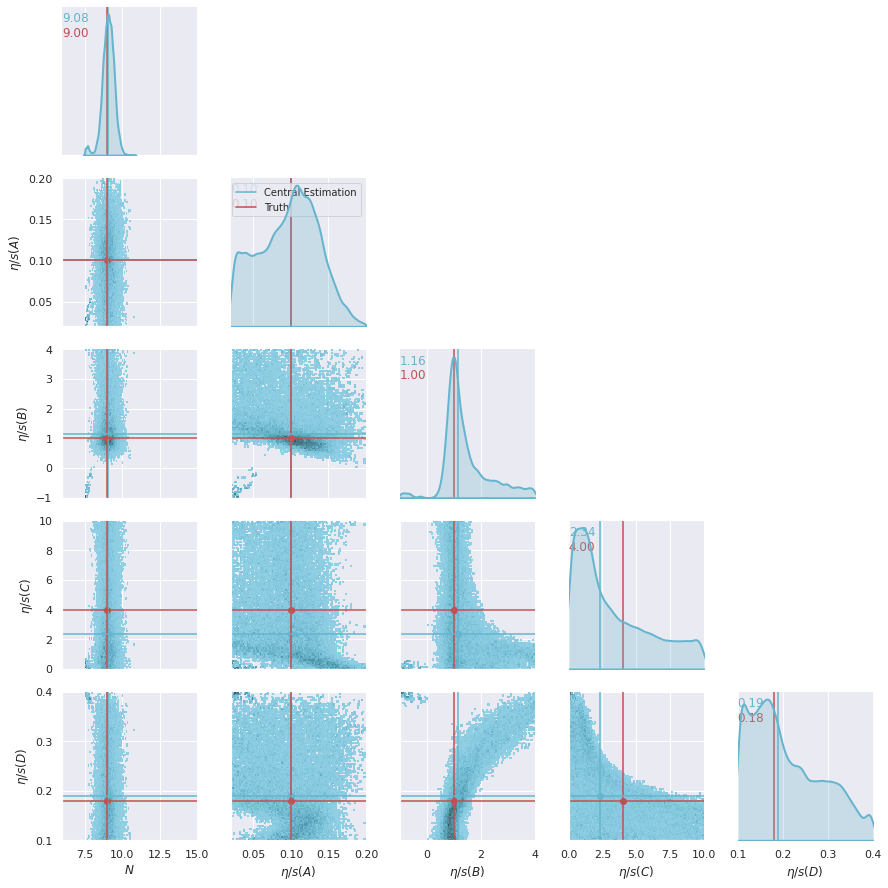

In [37]:
#### Block 24 #### Please refer to this number in your questions
g = sns.PairGrid(samples_df.iloc[:,:], corner=True, diag_sharey=False)
g.map_lower(sns.histplot, bins=100, color=sns.color_palette()[9])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[-1])
for n in range(Xdim):
    ax=g.axes[n][n]
    ax.axvline(x=parameters0[n], ls='-', c=sns.color_palette()[9], label='Central Estimation')
    ax.axvline(x=true_values[n], ls='-', c=sns.color_palette()[3], label='Truth')
    ax.text(0,0.9,s= f'{parameters0[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[9], fontsize=12)
    ax.text(0,0.8,s= f'{true_values[n]:.2f}', transform=ax.transAxes, color=sns.color_palette()[3], fontsize=12)
g.axes[1,1].legend(loc='best', fontsize=10)
for i in range(Xdim):
    for j in range(i+1):
        g.axes[i,j].set_xlim(*ranges[j])
        if i==j:
            g.axes[i,j].set_ylim(*ranges[i])
            
        else:
            g.axes[i,j].set_ylim(ymax=0)
            g.axes[i,j].axvline(x=parameters0[j], ls='-', c=sns.color_palette()[9])
            g.axes[i,j].axvline(x=true_values[j], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].axhline(y=parameters0[i], ls='-', c=sns.color_palette()[9])
            g.axes[i,j].axhline(y=true_values[i], ls='-', c=sns.color_palette()[3])
            g.axes[i,j].scatter(parameters0[j], parameters0[i], color=sns.color_palette()[9])
            g.axes[i,j].scatter(true_values[j], true_values[i], color=sns.color_palette()[3])
plt.tight_layout()
save_fig("Posterior_of_parameters")

For the viscosity parametrization, we are not interested in any individual parameters. Because, first they are highly-correlated, and second the meanning of each parameter is very specificy to the form of parametrization. It is more reasonable to direclty look at the functional posterior of $\eta/s(T)$

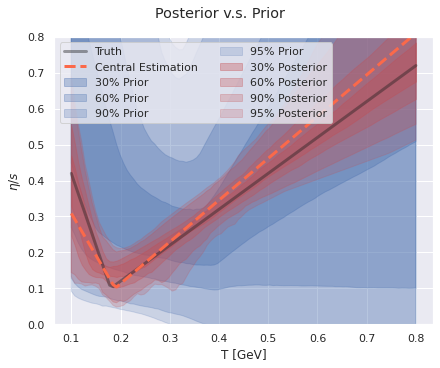

In [38]:
#### Block 25 #### Please refer to this number in your questions
Tt = np.linspace(0.1, .8, 100)
Nsamples = 10000
Nthin = samples_df.size//Nsamples
# prior samples of eta/s(T)
prior_etas = np.array([
        etas(Tt, row[1:]) for row in ((ranges[:,1]-ranges[:,0])*np.random.rand(Nsamples,Xdim)+ranges[:,0])
])
# posterior samples of eta/s(T)
posterior_etas = np.array([
        etas(Tt, row[1:]) for row in samples_df.iloc[::Nthin,:].values
])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5), sharex=False, sharey=False, constrained_layout=True)
fig.suptitle("Posterior v.s. Prior", wrap=True)
# plot prior, display 30%, 60%, 90%, and 100% credible limits
CLbins = [30,60,90, 95]
for CL, opacity in zip(CLbins, [.35,.3,.25,.2]):
    lower, upper = np.percentile(prior_etas, [50-CL/2., 50+CL/2.], axis=0)
    ax.fill_between(Tt,lower, upper,color=sns.color_palette()[0], alpha=opacity, label='{:d}% Prior'.format(CL))
# plot posterior, display 30%, 60%, and 90% credible limits
CLbins = [30,60,90, 95]
for CL, opacity in zip(CLbins, [.35,.3,.25,.2]):
    lower, upper = np.percentile(posterior_etas, [50-CL/2., 50+CL/2.], axis=0)
    ax.fill_between(Tt,lower, upper,color=sns.color_palette()[3], alpha=opacity, label='{:d}% Posterior'.format(CL))
        
ax.plot(Tt, etas(Tt, true_values[1:]),'k-', lw=3, label='Truth', alpha=.4)
ax.plot(Tt, etas(Tt, parameters0[1:]),'--', color=plt.cm.Reds(.5), lw=3, label='Central Estimation')

ax.legend(loc='upper left', ncol=2)
ax.set_ylim(0,.8)
ax.set_xlabel('T [GeV]')
ax.set_ylabel('$\eta/s$')
save_fig("Posterior_of_eta_s")

Finally, it is always important to check if the observables are well described.
It is possible that a poorly performing model produce a tightly-constrained posterior.

In [39]:
#### Block 26 #### Please refer to this number in your questions
Nsamples = 500
Nthin = samples_df.size//Nsamples
# prior parameter samples
prior_params = (ranges[:,1]-ranges[:,0])*np.random.rand(Nsamples,Xdim) + ranges[:,0]
# posterior parameter samples 
posterior_params =  samples_df.iloc[::Nthin,:].values

prior_obs = [np.concatenate(ToyModel(p)) for p in prior_params]
posterior_obs = [np.concatenate(ToyModel(p)) for p in posterior_params]

/home/weiyao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


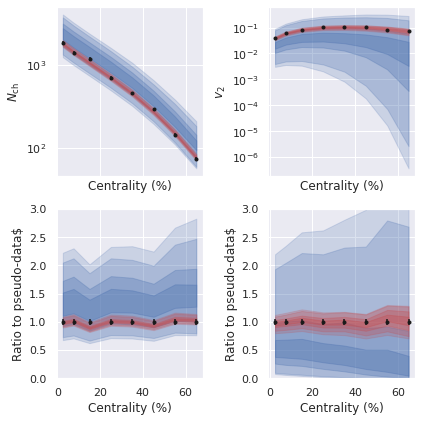

In [40]:
#### Block 27 #### Please refer to this number in your questions
fig, axes = plt.subplots(2,2, figsize=(6,6), sharex=True)
CLbins = [30,60,90, 95]
for isample, ilabel, color in zip([prior_obs, posterior_obs], 
                               ['prior','posterior'], 
                               [sns.color_palette()[0], sns.color_palette()[3]]):
    for CL, opacity in zip(CLbins, [.35, .3, .25, .2]):
        label = '{:d}% {}'.format(CL, ilabel)
        lower, upper = np.percentile(isample, [50-CL/2., 50+CL/2.], axis=0)
        axes[0,0].fill_between(cen, lower[:Nc], upper[:Nc], color=color, alpha=opacity, label=label)
        axes[0,1].fill_between(cen, lower[Nc:], upper[Nc:], color=color, alpha=opacity, label=label)
        axes[1,0].fill_between(cen, (lower/y_exp)[:Nc], (upper/y_exp)[:Nc], color=color, alpha=opacity, label=label)
        axes[1,1].fill_between(cen, (lower/y_exp)[Nc:], (upper/y_exp)[Nc:], color=color, alpha=opacity, label=label)
    
for ax,y,name in zip(axes[0], 
                    [y_exp[:Nc], y_exp[Nc:]],
                    [r"$N_{\rm ch}$", r"$v_2$"]):
    ax.errorbar(cen, y, yerr=y*.05, fmt='k.')
    ax.set_ylabel(name)
    ax.set_xlabel("Centrality (%)")
    
for ax,y,name in zip(axes[1], 
                    [y_exp[:Nc], y_exp[Nc:]],
                    ["Ratio to pseudo-data$"]*2):
    ax.errorbar(cen, y/y, yerr=y/y*.05, fmt='k.')
    ax.set_ylabel(name)
    ax.set_xlabel("Centrality (%)")
axes[0,0].semilogy()
axes[0,1].semilogy()
axes[1,0].set_ylim(0,3)
axes[1,1].set_ylim(0,3)
plt.tight_layout(True)
save_fig("Posterior_validation")

## Things to try:
1. Change the $p$ parameter in the defintion of the effective shear viscosity to $p=-3$ and repeat the analysis. Can you still constain the viscosity at high temperature?
2. Change the uncertainty level of the pseudodata and repeat.
3. Vary the number of PC. Is it always good to include more PC?
4. What if we do not include the non-linear transformation, and force Gaussian process to learn something that is clearly not normally distributed? 
5. What will happen if we use a different $\eta/s$ parametrization to generate the pseudodata. Or more generally, what can we learn from this piece-wise linearly form of $\eta/s$, given that nature may not have such form of $\eta/s(T)$?

# Back up
### 1 run TRENTo to generate the eccentricity information

In [389]:
def Load_Initial_Conditions(Run_TRENTo=False, Nevents=10000):
    if not Run_TRENTo:
        print("Loading pregenerted collision geometry information")
        cen, cenL, cenU, ET, ed, e2 = np.loadtxt(DATA_ID+"/Geometry_info.dat").T
    else:
        TRENTo_dtype=[('idx',np.int,1), ('b', np.float,1),
              ('npart', np.int,1), ('area', np.float, 1), 
              ('ET', np.float,1),
              ('e2', np.float,1), ('e3', np.float,1),  
              ('e4', np.float,1), ('e5', np.float,1),  
             ]
        print("Generating trento Pb+Pb with default params")
        proc = subprocess.run(
                ['trento', 'Pb','Pb', '{:d}'.format(Nevents)],
                stdout=subprocess.PIPE
            )
        results = np.empty(Nevents, dtype=TRENTo_dtype)
        for l, it in zip(proc.stdout.splitlines(), results):
            for dtype, value in zip(TRENTo_dtype, l.split()):
                it[dtype[0]] = value
        # sort by ET
        sorted_events = results[np.argsort(results['ET'])[::-1]]
        cenbin = np.array([0,5,10,20,30,40,50,60,70]) 
        cen = (cenbin[1:] + cenbin[:-1])/2.
        Ibin = (cenbin*Nevents/100.).astype(int)
        ET = np.array([sorted_events['ET'][il:ih].mean() for il, ih in zip(Ibin[:-1], Ibin[1:]) ])
        Area = np.array([sorted_events['area'][il:ih].mean() for il, ih in zip(Ibin[:-1], Ibin[1:]) ])
        e2 = np.array([sorted_events['e2'][il:ih].mean() for il, ih in zip(Ibin[:-1], Ibin[1:]) ])
        ed = ET/Area/5.076**2/20
        with open(DATA_ID+"Geometry_info.dat", 'w') as f:
            f.write("#cen\tcenL\tcenU\tET\te2\te3\n")
            for ic, icl, icu, iet, ied, ie2 in zip(cen, cenbin[:-1], cenbin[1:], ET, ed, e2):
                f.write(("{:1.1f}\t"*3+"{:1.4f}\t"*3+'\n').format(ic,icl,icu,iet,ied, ie2))

    return np.array([cen, ET, ed, e2])